# L1: Intro to Julia

Today we'll learn the basics of Julia, the programming language that we will be using for this course, by means of an example involving demand estimation.
## 0. Julia
### 0.1. Overview
Julia is a high-performance programming language well-suited for scientific and numerical computing. Some of its defining characteristics are:
- Just-in-time (JIT) compilation: Compilation is the process that "translates" a higher-level programming language (i.e., a language with a high level of abstraction that is understandable to humans) to a lower-level language (i.e. orders that are understandable to a computer). Julia compiles the code at run time (when the code is executed). It combines some of the speed advantages of ahead-of-time compilation (such as C or C++) with the flexibility and ease of use of interpreted languages (such as Python or R).
- Many pre-compiled languages are statically-typed: the type of an object (e.g. integer or string) needs to be annotated for the compiler, and cannot be modified or expressed at run time. Julia is very flexible in that types are themselves run-time objects, but can be declared in advance of compilation to accelerate performance.
- Multiple dispatch: Functions can be defined for different types of arguments. Efficient, specialized code can be generated automatically for each type. For example, arithmetic operations between integers and real numbers are handled differently.

### 0.2. Comparison to Other Languages
- **Stata:** Stata is great for applied work that involves mostly data cleaning and regressions. It has a very intuitive interface and many ready-made routines covering most econometric methods, without needing a lot of coding / programming from scratch. However, it is not the most suitable language for more customized applications (e.g. simulating data from a structural economic model and estimating counterfactuals). Julia can be much faster than Stata. However, as a relatively new language, it has relatively few pre-made packages (although there is an ```Econometrics.jl``` package that implements different type of regression estimators with a syntax very similar to R).
- **R:** Arguably, R is also primarily intended for data analysis, so there are many pre-existing packages for data cleaning and statistics that are well-documented. In comparison, Julia is more of a general programming language, where you can do all sorts of things. Things like numerical optimization and equation-solving, especially, can be much faster and computationally efficient in Julia.
- **Python:** Python is, like Julia, more of a general programming language. Julia can be much faster than Python, although Python has been around for longer, and so it has some pre-existing modules that Julia doesn't have (yet), one notable example being Machine Learning. I would say that Julia is especially useful with structural work with custom economic models, requiring numerical optimization or equation-solving.

### 0.3. Packages in Julia
**Packages** are libraries of functions that add certain capabilites to Julia, from basic tasks such as plotting or loading data to very specific tasks such as computing the NE of a particular class of games. The list of registered Julia packages can be found at http://pkg.julialang.org.

The commands for managing packages are found in the ```Pkg``` module, included in Julia's ```Base``` install. To access it, you can use ```import Pkg```, or you can use a closing square bracket ```]``` to enter package mode.

There are two ways to **add** (install) packages in Julia:
1. Adding the packages directly into your global installation. You do that with:
        
       import Pkg
       Pkg.add("MyPackage")
        
   or:
   
       ] add MyPackage
       
   The packages you install this way will be available everytime in every Julia session on your computer.

2. Using a directory with a ```Project.toml``` and a ```Manifest.toml``` files. This method provides an isolated set of packages for a particular project.
    
    1. The ```Project.toml``` file describes the project on a high level. It has optional fields for project name, version and authors, and it briefly lists the dependencies (packages used) and compatibility constraints.
    
    2. The ```Manifest.toml``` file is an absolute record of the state of the packages in the environment. It includes exact information about (direct and indirect) dependencies of the project.
    
    Given a ```Project.toml``` and a ```Manifest.toml``` file pair, it is possible to instantiate the exact same package environment every time / everywhere the project is active, which is extremely useful for reproducibility. Hence, this is the recommended method, especially if you are planning to submit your research to a journal that requires replication packages.
    
    The way to install packages to a project is the same as before, but when a project is active, the packages will be added to the ```Project.toml``` and ```Manifest.toml``` files, and will be available only within that project.
    
    Here's how you activate a project in the current directory ```"."```:

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Documents/GitHub/IAP-coding-2025`


The next step after activating the project is instantiating: this will install the packages that are needed for our project.

You can see the packages and versions that are included in this project as follows:

In [2]:
Pkg.instantiate()

In [3]:
Pkg.status()

Status `~/Documents/GitHub/IAP-coding-2025/Project.toml`
  [26cce99e] BasicInterpolators v0.7.1
  [a93c6f00] DataFrames v1.7.0
  [31c24e10] Distributions v0.25.116
  [4d6a76a9] Econometrics v0.2.11
  [a98d9a8b] Interpolations v0.15.1
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.10.0
  [91a5bcdd] Plots v1.40.9
  [1fd47b50] QuadGK v2.11.1
  [d519eb52] RegressionTables v0.7.8
  [8ba89e20] Distributed v1.11.0
  [37e2e46d] LinearAlgebra v1.11.0
  [9a3f8284] Random v1.11.0


After a package is installed and activated, if you want to **use** it inside a code file or a notebook, you need to tell Julia: ```using MyPackage``` — we'll see examples below.

## 1. Setting and Data Simulation
To get a flavor for what programming in Julia is like and some general features, we thought it would be fun to work with a structural model of demand and supply. We will be generating data according to the model, then using it to estimate the model's parameters and to simulate conterfactuals. (The model itself is not the primary focus of this course but, if you are interested, 14.273 covers this kind of models, and much more.)

### 1.1. Demand
We are going to observe data on $T = 1000$ Spanish towns. In each town, there are $N = 500$ consumers deciding between chicken paella and veggie paella, denoted by $j=1$ and $j=2$, respectively. Utility of consumer $i$ in town $t$ if they choose product $j$ is: 
$$u_{ijt} = \delta_j - \alpha p_{jt} + \xi_{jt} + \epsilon_{ij}, \quad j\in\{1,2\}.$$
They can also choose to not consume any paella, which we denote by $j=0$, in which case they receive utility $u_{i0t} = \epsilon_{i0}$. We assume that the $\epsilon_{ij}$ are iid across consumers and products, following an EV type I (or Gumbel) distribution. The $\xi_{jt}$ are town-product specific taste shocks following an iid $\mathcal{N}(0, \sigma)$ distribution, observed by  consumers and firms but not by the researcher.  

It can be shown (don't worry about the derivations) that, under these distributional assumptions, the expected market share of product $j$ in town $t$ will be:
\begin{equation}
s_{jt}(\mathbf{p}_{t}) = \frac{\exp(\delta_j - \alpha p_{jt} + \xi_{jt})}{1 + \sum_{k=1}^2 \exp(\delta_k - \alpha p_{kt} + \xi_{kt})}, \quad j\in\{1,2\}, \qquad s_{0t}(\mathbf{p}_{t}) = \frac{1}{1 + \sum_{k=1}^2 \exp(\delta_j - \alpha p_{kt} + \xi_{kt})}. \tag{1}
\end{equation}

Let's define a function that computes market shares given prices:

In [4]:
const T = 1000 
const N = 500
const J = 2

const α = 0.5
const δ = [2.0, 1.8]
const σ = 0.25;

In [5]:
using Random

Random.seed!(123) # Set the seed for the pseudo-random number generator
ξ = σ .* randn(T, J) # Generate a T x J random matrix with iid N(0,1) entries and re-scale by σ

function shares(p::Matrix; α=α, δ=δ, ξ=ξ)
    
    # Inputs 
    # p : A TxJ matrix of prices

    # Outputs 
    # s : A TxJ matrix of market shares

    s = zeros(Float64, T, J) # Create a T x J matrix of all zeros, with type Float64

    for t = 1:T
        s[t, :] = exp.(δ .- α .* p[t, :] .+ ξ[t, :])./(1.0 .+ sum(exp.(δ .- α .* p[t, :] .+ ξ[t, :])))
    end

    return s 
    
end

function shares(p::Vector; α=α, δ=δ, ξ=ξ, t=1)
    
    # Inputs 
    # p : A 1xJ vector of prices

    # Outputs 
    # s : A 1xJ vector of market shares

    s = exp.(δ .- α .* p .+ ξ[t, :])./(1.0 .+ sum(exp.(δ .- α .* p .+ ξ[t, :])))
end;

<div class="alert alert-block alert-success">
<b>Coding Tips:</b>
<ol>
    <li> Use <code>const</code> to declare immutable constants (these should not be modified during the execution of the code).</li>
    <li> To index a vector or a matrix in Julia (i.e., refer to one of its elements), we use square brackets. For example, if <code>p</code> were a matrix, <code>p[1, 1]</code> would refer to the element in its first row, first column. We can also use a colon, e.g., <code>p[1, :]</code>, to refer to the entire first row (viewed as a vector); this is called "slicing." </li>
    <li> When we want apply scalar operations and functions to a vector or a matrix element-wise, we need to "broadcast" them. In Julia, this is achieved by using a dot after the function name or before the operation symbol. For example, with <code>exp.(δ .- α .* p[j, :])</code>, we take the exponential of each element of the vector. Some operations (e.g. the sum or difference) needed to be broadcasted in the past, now they don't have to be anymore; I tend to be conservative and broadcast all element-wise operations.</li> 
    <li> We define functions with <code>function fname(arguments)</code>. We then write all the operations we want the function to perform, and tell Julia what we want the function to output with a <code>return</code> statement. For simple functions, the <code>return</code> statement is not needed; the function will simply return the last variable you compute (see example above). You finally close the function definition with an <code>end</code> statement. Unlike Python, indenting the function definition is not necessary, but I find it improves readability of your code. </li>
    <li> Julia makes a distinction between positional and keyword arguments to functions <code>f(pos1, pos2, ... ; kw1, kw2, ...)</code>. When you call the function, positional arguments will be determined by their order, while keyword arguments need to be referred to by name, but can be entered in any order. In our example, <code>shares(p, α=α, δ=δ, ξ=ξ)</code> and <code>shares(ξ=ξ, δ=δ, α=α, p)</code> would give the same result. Also, notice that I am making our functions depend explicitly on the parameters (which are the default values, and so, can be omitted when we call the function). This is because later we are going to estimate the parameters of the model, pretending that we don't know the ground truth, and for our counterfactual computation we will want to use our estimates.</li>
    <li> Multiple dispatch: in Julia you can define the same function for different types of arguments, so that the same function can flexibly adapt to its inputs. Here we define a function that computes shares for all towns, when the input is a matrix of prices, or for just one town, when the input is a vector of prices.</li>
    <li> Loops: a "loop" is a way of telling the computer to perform an operation many times. The previous code snippet contains an example of a "for"-loop: <code>for t = 1:T</code>. This tells Julia to perform the operation inside the loop replacing the variable <code>t</code> with each value from 1 to $T$. We also need to close "for"-loops with an <code>end</code> statement.
    <li> To optimize the performance of your code, it is helpful to declare the type of the arguments. For example, in <code>shares(p::Matrix)</code>, we are telling Julia that the input is a matrix. Similarly, try to initialize objects with the right type, e.g. <code>s = zeros(Float64, T, J)</code>. ("Floats" are real, non-integer numbers. The 64 indicates we will use 64 bits of memory to store each number — 64 is the standard, which allows more precision and a larger range of possible values than Float16 or Float32.) You should also preallocate memory when possible. </li>
    <li> Notice that I'm writing <code>1.0 .+ sum(exp.(δ .- α .* p[j, :]))</code> rather than <code>1 .+ sum(exp.(δ .- α .* p[j, :]))</code>. The difference is that <code>1.0</code> represents a float (real number) and <code>1</code> is an integer. If you try to add integers and floats, Julia will automatically convert everything to floats and your code will still run properly, but it is faster to operate with objects of the same type.</li>
</ol>
</div>

In [13]:
# Example: exp([0.0, 0.0]) would give you a broadcast error
exp.([0.0, 2.0])


2-element Vector{Float64}:
 1.0
 7.38905609893065

### 1.2. Supply
In each town, there are two restaurants, one that specializes in chicken paellas, and one that specializes in veggie paellas. The prices are set in monopolistic competition, where each restaurant chooses price to maximize profits given the other restaurant's price and the expected demand:

$$\max_{p_{jt}} N \cdot s_{jt}(\mathbf{p}_t) \cdot (p_{jt} - c_{jt}) \quad \text{subj. to } s_{jt}(\mathbf{p}_{t}) = \frac{\exp(\delta_j - \alpha p_{jt} + \xi_{jt})}{1 + \sum_{k=1}^2 \exp(\delta_k - \alpha p_{kt} + \xi_{kt})}, \quad j \in \{1,2\}.$$

Here, $c_{jt}$ is marginal cost. For simplicity, let us supose that $\log c_{jt} \sim \mathcal{N}(0,0.25)$, iid across towns and products, and that this is observed by the econometrician.

There are two ways we could solve this:
1. We could analytically derive the BR functions, and solve for the equilibrium. The FOC for each firm (you don't need to derive this) is the solution to:
$$p_{jt} = c_{jt} - \frac{s_{jt}(\mathbf{p}_t)}{\partial s_{jt}(\mathbf{p}_t)/\partial p_{jt}},$$ where $\partial s_{jt}(\mathbf{p}_t)/\partial p_{jt} = -\alpha s_{jt}(\mathbf{p}_t) (1 - s_{jt}(\mathbf{p}_t))$ is the own-price elasticity of demand. For each town, this defines a 2x2 system of equations in $p_{1t}, p_{2t}$ that can be solved in a number of ways (we'll learn more about these in Lecture 7).
2. We could pick an initial guess for $p_{1t}$ and compute the best response for firm 2 by directly solving the maximization problem above (more on optimization in Lecture 6). Then, we can compute firm 1's best response to that. By iterating this procedure until convergence, we should arrive at the Nash Equilibrium which, for this game, is unique.

Let's see how these two methods would be implemented below:

In [41]:
using NLsolve, Optim, LinearAlgebra

c = exp.(0.25randn((T, J))) # Generate T x J random marginal costs

# Method 1 ---------------------------------------------------------------------

# FOC of each firm:
FOC(p::Matrix{Float64}; α=α, δ=δ, ξ=ξ) = c::Matrix{Float64} .+ 1.0 ./ (α .* (1.0 .- shares(p, α=α, δ=δ, ξ=ξ)))

# Solve for equilibrium as fixed point, more in L7:
function eq_prices_FOC(; α=α, δ=δ, ξ=ξ)
    res = fixedpoint(x -> FOC(x, α=α, δ=δ, ξ=ξ), ones(Float64, T, J))
    return res.zero
end

@time p1 = eq_prices_FOC()
@time p1 = eq_prices_FOC()

# # Method 2 ---------------------------------------------------------------------

# # Function to compute profit given own and competitor's price:
function profit(own_p::Float64, other_p::Float64; α=α, δ=δ, ξ=ξ, t=1, j=1) 
   p = j == 1 ? [own_p, other_p] : [other_p, own_p]
   return N * shares(p, t=t, α=α, δ=δ, ξ=ξ)[j] * (own_p - c[t, j]::Float64)
end

# # Function to compute successive BR, more on optimization in L6:
# function eq_prices_BR(; α=α, δ=δ, ξ=ξ, tol = 1e-20, max_iter = 10000)
    
#     p = zeros(Float64, T, J)
    
#     for t = 1:T
#         p_old = [1.0, 1.0]
#         p_new = [1.0, 1.0]
#         error = 1000.0
#         iter = 0
        
#         while (error > tol) & (iter < max_iter)
#             res = optimize(x -> -profit(x[1], p_old[1], α=α, δ=δ, ξ=ξ, t=t, j=2), [p_old[2]]) # Compute 2's BR
#             br2 = res.minimizer[1]
#             res = optimize(x -> -profit(x[1], br2, α=α, δ=δ, ξ=ξ, t=t, j=1), [p_old[1]])      # Compute 1's BR
#             br1 = res.minimizer[1]
#             p_new = [br1, br2]
#             error = norm(p_new .- p_old)
#             iter += 1
#             p_old = copy(p_new)
#         end
        
#         p[t, :] = p_new
#     end
    
#     return p
# end

# @time p2 = eq_prices_BR()
# @time p2 = eq_prices_BR()

# @show maximum(abs.(p1 .- p2));

  0.177350 seconds (841.62 k allocations: 102.906 MiB, 6.14% gc time, 89.96% compilation time)
  0.012928 seconds (192.32 k allocations: 69.711 MiB, 47.17% gc time)


profit (generic function with 1 method)

<div class="alert alert-block alert-success">
<b>Coding Tips:</b>
<ol>
    <li> You can define simple functions in one line with the <code>fname(x) = f(x)</code> rhetoric.</li>
    <li> We will learn more about <code>fixedpoint</code> and <code>optimize</code> later in the course. For now, you just need to know that the first argument is the function for which you want to find a fixed point (i.e. F(x) = x) or minimize, and the second argument is the starting value. Functions need to be defined for arrays, rather than scalars, that's why, to extract the solution as a scalar, I index <code>br2 = res.minimizer[1]</code>. </li>
    <li> You can also define anonymous functions (without a name) as <code>x -> f(x)</code>. This is useful when the function itself is passed as an argument to another function. For example, in <code>fixedpoint(x -> FOC(x; α=α, δ=δ, ξ=ξ), ones(Float64, T, J))</code>, I am creating an anonymous function that computes the RHS of the firms' FOC after fixing the keyword arguments <code>α, δ, ξ</code>.</li>
    <li> A useful syntax to express conditional statements is <code>p = j == 1 ? [own_p, other_p] : [other_p, own_p]</code>. This means: if <code>j == 1</code>, then assign <code>p = [own_p, other_p]</code>, otherwise assign <code>p = [other_p, own_p]</code>.</li>
    <li> Expressions with an @ sign are called "macros." Use the macro <code>@time</code> to time the execution of your functions. Notice that the first time you run a function, it takes much longer because of compilation time. By the magic of JIT compilation, when we run the same function again, it doesn't need to be re-compiled, and so it is much faster. Use the macro <code>@show</code> to display results of operations in a nice way. </li>
    <li>In the definition of the functions I use <code>c::Matrix{Float64}</code> to let Julia know the type of the global <code>c</code>, which is defined outside the function. This is optional, but it can help greatly reduce compilation time.</li>
    </ol>
</div>

Let us now simulate the market shares given those prices:

In [17]:
using Distributions

function sim_shares(p::Matrix{Float64})
    
    s = zeros(Float64, T, J)
    
    for t = 1:T
        ϵ = rand(Gumbel(0, 1), N, J+1) # Idiosyncratic iid EV type I taste shocks
        u = (δ .- α .* p[t, :] .+ ξ[t, :]::Vector{Float64})' .+ ϵ[:, 1:2] # Utility of products 1 and 2
        s[t, 1] = mean((u[:, 1] .> u[:, 2]) .& (u[:, 1] .> ϵ[:, 3])) # Market share of product 1
        s[t, 2] = mean((u[:, 2] .> u[:, 1]) .& (u[:, 2] .> ϵ[:, 3])) # Market share of product 2
    end
    
    return s
end

s = sim_shares(p1)

1000×2 Matrix{Float64}:
 0.32   0.386
 0.292  0.302
 0.306  0.362
 0.372  0.304
 0.38   0.188
 0.356  0.286
 0.334  0.26
 0.284  0.314
 0.394  0.256
 0.348  0.202
 0.37   0.292
 0.374  0.242
 0.334  0.344
 ⋮      
 0.382  0.282
 0.324  0.334
 0.402  0.26
 0.32   0.296
 0.412  0.336
 0.342  0.282
 0.334  0.342
 0.346  0.35
 0.356  0.294
 0.306  0.36
 0.306  0.288
 0.354  0.24

<div class="alert alert-block alert-success">
<b>Coding Tips:</b>
<ol>
    <li> The <code>Distributions</code> package contains functions relating to many probability distributions (for example, the Gumbel or EV type I distribution).</li>
    <li> The object <code>u[:, 1] .> u[:, 2]</code> is a "boolean" vector, meaning that each of its entries is either true or false. When performing numeric operations on it, it is treated as a "bit" vector, essentially an indicator function with numerical value 1 for true and 0 for false.</li>
    </ol>
</div>

In [19]:
# Careful, if you don't broadcast the > operation, Julia will use the lexicographic order between vectors:
@show [1, 2] > [1, 1]
@show [2, 1] > [1, 2]
@show [1, 2] > [1, 3]

# Vs:
@show [1, 2] .> [1, 1];

[1, 2] > [1, 1] = true
[2, 1] > [1, 2] = true
[1, 2] > [1, 3] = false
[1, 2] .> [1, 1] = Bool[0, 1]


Finally, let us make a ```DataFrame``` out of our simulated dataset.

In [20]:
using DataFrames

df = DataFrame(t = 1:T, p1 = p1[:, 1], p2 = p1[:, 2], s1 = s[:, 1], s2 = s[:, 2], c1 = c[:, 1], c2 = c[:, 2])

first(df, 5) # Inspect the first 5 rows

Row,t,p1,p2,s1,s2,c1,c2
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,4.24923,3.92364,0.32,0.386,1.25605,0.793268
2,2,3.75415,3.95406,0.292,0.302,0.820287,1.05945
3,3,3.71179,3.90717,0.306,0.362,0.864106,0.769283
4,4,3.72335,4.04101,0.372,0.304,0.650412,1.12817
5,5,4.28744,4.46361,0.38,0.188,1.05875,1.93018


## 2. Estimation
Suppose we are interested in estimating the demand parameters, $(\delta_1, \delta_2, \alpha)$. Manipulating equation (1), we can write:
$$\log[s_{jt}(\mathbf{p}_t)/s_{0t}(\mathbf{p}_t)] = \delta_j - \alpha p_{jt} + \xi_{jt}.$$

This suggest that we might be able to estimate the parameters by a linear regression of $\log(s_{jt}/s_{0t})$ on product indicators and price. Let's try that!

### 2.1. OLS

Let's compute $\log(s_{jt}/s_{0t})$ in our dataframe:

In [21]:
df.s0 = 1.0 .- df.s1 .- df.s2
df.log_rel_share1 = log.(df.s1 ./ df.s0)
df.log_rel_share2 = log.(df.s2 ./ df.s0);

Notice that our dataframe is in "wide" format. To run our regression we would like to have it in "long" format. The way of doing that in Julia is a bit more complicated than in Stata:

In [22]:
first(df, 5)

Row,t,p1,p2,s1,s2,c1,c2,s0,log_rel_share1,log_rel_share2
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,4.24923,3.92364,0.32,0.386,1.25605,0.793268,0.294,0.0847412,0.272258
2,2,3.75415,3.95406,0.292,0.302,0.820287,1.05945,0.406,-0.329599,-0.295926
3,3,3.71179,3.90717,0.306,0.362,0.864106,0.769283,0.332,-0.0815499,0.0865092
4,4,3.72335,4.04101,0.372,0.304,0.650412,1.12817,0.324,0.13815,-0.0637158
5,5,4.28744,4.46361,0.38,0.188,1.05875,1.93018,0.432,-0.128254,-0.831984


In [23]:
cols_not_to_stack = ["t", "s0"]
cols_to_stack = ["p", "s", "c", "log_rel_share"]

df_long = df |>
   x -> select(x, cols_not_to_stack, [cols_to_stack .* "$j" for j in 1:J] .=> ByRow(tuple) .=> ["$j" for j in 1:J]) |>
   x -> stack(x, ["$j" for j in 1:J], variable_name = :product) |>
   x -> select(x, cols_not_to_stack, :product, :value => cols_to_stack)

df_long.product = parse.(Int, df_long.product);

<div class="alert alert-block alert-success">
<b>Coding Tips:</b>
<ol>
    <li> This example introduces the "piping" operator, which allows for functional chaining, i.e. <code>y = x |> f |> g |> h</code> will be the same as <code>y = h(g(f(x)))</code>. It is useful in making the code more readable when the functions are somewhat complex. 
    Here we are applying three anonymous functions:
    <ol>
        <li> The first function returns a dataframe with <code>:t, :s0</code>, then turns the columns <code>:p1, :s1, :c1, :log_rel_share1</code> into a single tuple-valued variable named 1, and columns <code>:p2, :s2, :c2, :log_rel_share2</code> into a single tuple-valued variable named 2. The reason will become clear in the next step.</li>
        <li> <code>stack</code> is the function that reshapes dataframes from wide to long. It works very differently from Stata: in Julia, <code>stack(df, ["x", "y", "z"])</code> will create a long dataframe with two new variables. The first one, named <code>:variable</code> by default, will contain the labels "x," "y," and "z" as strings (in our examples, the labels are "1" and "2" and I'm telling Julia to name this column "product"). The second one, named <code>:value</code> will contain the values of <code>x</code>, <code>y</code>, and <code>z</code> in the corresponding row. Here, this is a tuple containing <code>:p, :s, :c, :log_rel_share</code> for each product.</li>
        <li> The third function "un-tuples" the variables in <code>:value</code>.</li>
    </ol></li>
    <li> Notice that <code>"&#36;j"</code> can be used to insert a variable <code>j</code> inside a string. The simplest case <code>["$j" for j in 1:J]</code> just returns <code>["1", "2"]</code> but I do recommend using the more complicated expression as a best practice: imagine you decide to have 100 products instead of 2. Then, this way, the code adaps automatically, instead of manually having to find and replace every instance of <code>["1", "2"]</code>.</li>
    <li> I am also using the <code>*</code> operator to append strings, see examples below.</li>
    <li> The function <code>parse(type, x)</code> turns x into a given type. In this case, we are expressing the product back as an integer, rather than a string. This works better with <code>DummyCoding()</code> in the <code>Econometrics</code> package.</li>
    </ol>
</div>

In [24]:
# Examples of the * operator between strings
@show "This" * " and that"
@show ["A", "B"] .* "C"; # ["A", "B"] * "C" would give a broadcasting error

"This" * " and that" = "This and that"
["A", "B"] .* "C" = ["AC", "BC"]


In [25]:
first(df_long, 5)

Row,t,s0,product,p,s,c,log_rel_share
,Int64,Float64,Int64,Float64,Float64,Float64,Float64
1,1,0.294,1,4.24923,0.32,1.25605,0.0847412
2,2,0.406,1,3.75415,0.292,0.820287,-0.329599
3,3,0.332,1,3.71179,0.306,0.864106,-0.0815499
4,4,0.324,1,3.72335,0.372,0.650412,0.13815
5,5,0.432,1,4.28744,0.38,1.05875,-0.128254


In [27]:
using Econometrics

OLS = fit(EconometricModel, @formula(log_rel_share ~ 0 + product + p), df_long, 
    contrasts = Dict(:product => DummyCoding()))

Continuous Response Model
Number of observations: 2000
Null Loglikelihood: 77.89
Loglikelihood: 166.16
R-squared: 0.0845
LR Test: 176.54 ∼ χ²(3) ⟹  Pr > χ² = 0.0000
Formula: log_rel_share ~ 0 + product + p
Variance Covariance Estimator: OIM
───────────────────────────────────────────────────────────────────────────
                PE         SE      t-value  Pr > |t|       2.50%     97.50%
───────────────────────────────────────────────────────────────────────────
product: 1  -0.598523  0.0829085  -7.21907    <1e-12  -0.761119   -0.435926
product: 2  -0.696395  0.079948   -8.71061    <1e-17  -0.853186   -0.539605
p            0.135604  0.0202797   6.68667    <1e-10   0.0958321   0.175375
───────────────────────────────────────────────────────────────────────────

<div class="alert alert-block alert-success">
<b>Coding Tips:</b>
<ol>
    <li> See the <a href="https://nosferican.github.io/Econometrics.jl/dev/">documentation for the Econometrics package</a> (it has many useful features, and the documentation makes the link with Stata commands clear!).</li>
    <li> Some things to notice: in the <code>@formula(log_rel_share ~ 0 + product + p)</code>, I am telling Julia not to include a constant (so that we can have dummies for both product 1 and 2 instead of omitting a base category). With the option <code>contrasts = Dict(:product => DummyCoding())</code>, I am telling Julia that <code>:product</code> is a categorical variable that should be included as dummies in the regression.</li>
</div>

The ```Econometrics``` package also allows us to get heteroskedasticity-robust standard errors, but it does not supply them by default. They can be computed using different numerical methods (HC0 to HC4, same as in R's ```vcovHC```). The recommended one by Long & Ervin (2000) is HC3, so I will be using those here. You can get them with:

In [17]:
OLS = fit(EconometricModel, @formula(log_rel_share ~ 0 + product + p), df_long, 
          contrasts = Dict(:product => DummyCoding()), vce = HC3)

Continuous Response Model
Number of observations: 2000
Null Loglikelihood: 86.20
Loglikelihood: 177.31
R-squared: 0.0871
LR Test: 182.21 ∼ χ²(3) ⟹  Pr > χ² = 0.0000
Formula: log_rel_share ~ 0 + product + p
Variance Covariance Estimator: HC3
───────────────────────────────────────────────────────────────────────────
                PE         SE      t-value  Pr > |t|       2.50%     97.50%
───────────────────────────────────────────────────────────────────────────
product: 1  -0.622147  0.0899333  -6.91787    <1e-11  -0.79852    -0.445774
product: 2  -0.719216  0.0865892  -8.30607    <1e-15  -0.889031   -0.549402
p            0.141469  0.0221472   6.38765    <1e-09   0.0980347   0.184903
───────────────────────────────────────────────────────────────────────────

### 2.2. IV
Look again at the OLS estimates. Oops, they are quite bad — we are estimating a positive coefficient on price! 

As you probably remember from your econometrics course, it is usually not a good idea to estimate demand parameters by just regressing quantities on prices, because of simultaneity bias. In our setting, $E[\xi_{jt}p_{jt}] \neq 0$ because the monopolistic firms take taste shocks into account when deciding prices. We need a source of variation that shifts prices but is uncorrelated with taste shocks... like a cost shifter that shocks supply. But we are assuming that marginal costs are observed in our setting! Let's try using them as an instrument for prices:

In [28]:
IV = fit(EconometricModel, @formula(log_rel_share ~ 0 + product + (p ~ c)), df_long, 
         contrasts = Dict(:product => DummyCoding()), vce = HC3)

Continuous Response Model
Number of observations: 2000
Null Loglikelihood: 77.89
Loglikelihood: -234.83
R-squared: NaN
LR Test: -625.43 ∼ χ²(3) ⟹  Pr > χ² = 1.0000
Formula: log_rel_share ~ 0 + product + (p ~ c)
Variance Covariance Estimator: HC3
──────────────────────────────────────────────────────────────────────────
                PE         SE      t-value  Pr > |t|      2.50%     97.50%
──────────────────────────────────────────────────────────────────────────
product: 1   1.99426   0.133617    14.9252    <1e-47   1.73222    2.2563
product: 2   1.80312   0.129293    13.946     <1e-41   1.54955    2.05668
p           -0.500903  0.0327991  -15.2718    <1e-49  -0.565227  -0.436579
──────────────────────────────────────────────────────────────────────────

That's much better! You can use ```RegressionTables.jl``` to print regression tables:

In [30]:
using RegressionTables

# A dictionary with variable => variable label
labels = Dict("product: 1" => "Product 1", "product: 2" => "Product 2", 
              "p" => "Price", "log_rel_share" => "log(Relative Share)")

regtable(OLS, IV, regression_statistics = [:nobs], labels = labels, 
         groups = ["OLS", "IV"], print_estimator_section = false)


---------------------------------
               OLS          IV   
            ---------   ---------
             log(Relative Share) 
            ---------------------
                  (1)         (2)
---------------------------------
Product 1   -0.599***    1.994***
              (0.083)     (0.134)
Product 2   -0.696***    1.803***
              (0.080)     (0.129)
Price        0.136***   -0.501***
              (0.020)     (0.033)
---------------------------------
N               2,000       2,000
---------------------------------



## 3. Counterfactuals: Effects of a Tax

Suppose now that the Spanish government wants to disincentivize consumption of meat by imposing a tax on chicken paella, but they do not want to decrease consumer surplus by much, so they have asked us how consumer surplus and profits would change for different values of the tax. Let's use our estimated demand parameters to answer this question.

First, the expression for expected consumer surplus with EV type I idiosyncratic utilities is:
$$E[\max_{j \in \{0, 1, 2\}} u_{ijt}] = \frac{1}{\alpha}\log\Big( 1 + \sum_{j=1}^2 \exp(\delta_j - \alpha p_{jt} + \xi_{jt})\Big) + \text{const.}$$

(The constant does not matter because it will difference out when we compare welfare with and without the tax).

To compute that based on our IV estimation, let's extract the coefficients and residuals:

In [35]:
δ_hat = coef(IV)[1:2]
α_hat = -coef(IV)[3]
ξ_hat = zeros(Float64, T, J)
ξ_hat[:, 1] = residuals(IV)[df_long.product .== 1]
ξ_hat[:, 2] = residuals(IV)[df_long.product .== 2];

Now let's create a function that computes the equilibrium prices as a function of the taxation level. We will use the first method above, modifying the FOC accordingly (you can derive it at home!):

In [36]:
function FOC_tax(p::Matrix{Float64}; tax::Float64, α=α_hat, δ=δ_hat, ξ=ξ_hat)
    tax_mult = ones(Float64, T, J)
    tax_mult[:, 1] .+= tax # The tax multiplier is 1 + tax rate
    return c::Matrix{Float64} .+ 1.0 ./ (α .* tax_mult .* (1.0 .- shares(tax_mult .* p, α=α, δ=δ, ξ=ξ)))
end

function eq_prices_FOC_tax(tax; α=α_hat, δ=δ_hat, ξ=ξ_hat)
    res = fixedpoint(x -> FOC_tax(x, tax=tax, α=α, δ=δ, ξ=ξ), p1)
    return res.zero
end;

Finally, let's define a function that computes the difference in expected consumer surplus, averaged across towns, with and without the tax:

In [37]:
CS(p; α=α_hat, δ=δ_hat, ξ=ξ_hat) = 1.0/α * mean(log.(1.0 .+ sum(exp.(δ' .- α .* p .+ ξ), dims = 1)))

CS_no_tax = CS(p1)

function CS_diff(tax; α=α_hat, δ=δ_hat, ξ=ξ_hat)
    p_tax = eq_prices_FOC_tax(tax, α=α, δ=δ, ξ=ξ)
    tax_mult = ones(Float64, T, J)
    tax_mult[:, 1] .+= tax
    return CS(tax_mult .* p_tax) - CS_no_tax::Float64
end

tax_grid = 0.1:0.1:1.0 # [0.1, 0.2, ..., 1.0]
CS_results = [CS_diff(tax) for tax in tax_grid]; 

<div class="alert alert-block alert-success">
<b>Coding Tips:</b>
<ol>
    <li> In <code>sum(exp.(δ' .- α .* p .+ ξ), dims = 1)</code>, we are indicating that we want to do the sum row-wise: along the first dimension of the array. That is, for each row, we want to sum the elements in each column of that row (rather than summing all elements in the matrix). See examples of this below.</li>
    <li> A "comprehension" is a compact way to define arrays via a for loop. For example, <code>[CS_diff(tax) for tax in tax_grid]</code>.</li>
</div>

What about profits (let's express it in per consumer terms, so that they are in the same units as the CS)?

In [42]:
profits_results = zeros(Float64, length(tax_grid), J)

for j = 1:J
    profit_no_tax = [profit(p1[t, j], p1[t, end-j+1]; α=α_hat, δ=δ_hat, ξ=ξ_hat, t=t, j=j) for t=1:T]./N

    function profit_diff(tax; α=α_hat, δ=δ_hat, ξ=ξ_hat)
        p_tax = eq_prices_FOC_tax(tax, α=α, δ=δ, ξ=ξ)
        tax_mult = ones(Float64, T, J)
        tax_mult[:, 1] .+= tax
        profit_tax = shares(tax_mult .* p_tax, α=α, δ=δ, ξ=ξ)[:, j] .* (p_tax[:, j] .- c[:, j]::Vector{Float64})
        return mean(profit_tax .- profit_no_tax::Vector{Float64})
    end

    tax_grid = 0.1:0.1:1.0
    profits_results[:, j] = [profit_diff(tax) for tax in tax_grid];
end

Finally, we will learn how to make plots to visualize the results:

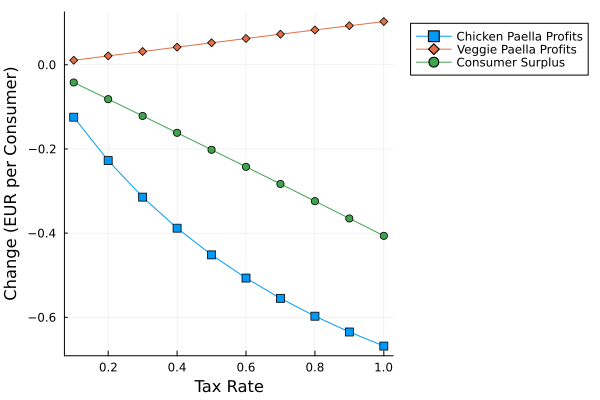

In [43]:
using Plots

plot(tax_grid, profits_results, 
    markershape = [:rect :diamond], # Notice there are no commas: This is a 1x2 matrix, respecting the number of columns in the data
    label = ["Chicken Paella Profits" "Veggie Paella Profits"],
    xlabel = "Tax Rate", ylabel = "Change (EUR per Consumer)",
    legend = :outertopright)

# Forgot to add something? No problem! Use plot! with an exclamation mark:
plot!(tax_grid, CS_results, 
    markershape = :circle,
    label = "Consumer Surplus")

## Aside: Parallel Computing in Julia 

Loops with computationally expensive calculation can be inefficient. Instead we can leverage threads and/or processes to run multiple computations at once. 

In [44]:
tax_grid = 0.1:0.0001:5.0 

0.1:0.0001:5.0

In [45]:
tax_grid = 0.1:0.0001:5.0 
x = zeros(size(tax_grid))
@time for i = 1:size(tax_grid,1) 
       CS(tax_grid[i])
end

  0.640949 seconds (1.12 M allocations: 791.506 MiB, 16.88% gc time, 22.15% compilation time)


In [46]:
using Distributed
addprocs(5)
nprocs()
@everywhere using NLsolve, Optim, LinearAlgebra, Statistics

@everywhere begin 
    const T = 1000 
    const N = 500
    const J = 2
    const α = 0.5
    const δ = [2.0, 1.8]
    const σ = 0.25;
    ξ = σ .* randn(T, J) # Generate a T x J random matrix with iid N(0,1) entries and re-scale by σ
    CS(p; α=α, δ=δ, ξ=ξ) = 1.0/α * mean(log.(1.0 .+ sum(exp.(δ' .- α .* p .+ ξ), dims = 1)))
end

y = zeros(size(tax_grid))

@time @distributed for i = 1:size(tax_grid,1) 
   CS(tax_grid[i])
end

  0.005059 seconds (5.39 k allocations: 263.562 KiB, 98.12% compilation time)


Task (runnable, started) @0x0000000283d96a40

In [47]:
rmprocs(workers())
nprocs()

1

## Plan for the Next Sessions

In the next sessions, we will learn:
- L3: Function approximation 
- L4: Numerical integration and differentiation
 L5: Differential equations
- L6: Numerical optimization
- L7: Zero-solvers and fixed-point algorithms
- L8: Review with an economic application

## Additional Resources
- [Julia Documentation](https://docs.julialang.org/en/v1/). The sections "Manual > Noteworthy Differences from other Languages" and "Manual > Performance Tips" could be especially interesting for those of you with prior experience with other programming languages.
- [Quantitative Economics with Julia](https://julia.quantecon.org/intro.html). A course by Jesse Perla, Thomas J. Sargent and John Stachurski. It goes over basic concepts in programming, how these work in Julia, and then specific economic applications. It also has exercises with solutions, which is a great way to test your knowledge.
- Fedor Iskhakov has compiled a [collection of publicly available learning resources in computational economics and structural modeling](https://fedor.iskh.me/resources). Most of them are not specific to Julia, but can be helpful if you use other programming languages or want to learn more about the numerical methods that we will be using in this course.
- Judd, Kenneth L. (1998) *Numerical methods in economics.* Cambridge, MA: MIT Press. Many of the theoretical results from this lecture notes are drawn from this book. It won't teach you to code in Julia, but it is a wonderful reference for the theory behind the numerical methods we're using.
- Relatedly, Ken Judd has a [2020 course on computational economics](https://github.com/KennethJudd/CompEcon2020). The website contains basically only the slides for the course, but it is very exhaustive (27 lecture notes!).